In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

from copy import deepcopy
import missingno as msno
import time

from StochasticGradientDescent import SGD
from ScaledConjugateGradient import SCG
from LeapFrog import LFrog
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer

from scipy.stats import shapiro
from scipy import stats
from scipy.stats import kruskal

In [3]:
train_images = pd.read_csv('./data/FashionMNIST/fashion-mnist_train.csv')
test_images = pd.read_csv('./data/FashionMNIST/fashion-mnist_test.csv')

### Check for Missing values

In [4]:
(train_images.isna().sum() > 0).sum()

0

In [5]:
(test_images.isna().sum() > 0).sum()

0

### Check for Imbalanced class data

In [6]:
train_labels = train_images.pop('label')
test_labels = test_images.pop('label')

train_images = train_images.values.reshape(-1,28,28)
test_images = test_images.values.reshape(-1,28,28)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [7]:
train_names = [class_names[u] for u in train_labels]
df_train_names = pd.DataFrame({'Label': train_labels, 'Name':train_names})
df_train_names.head()

,Label,Name
0,2,Pullover
1,9,Ankle boot
2,6,Shirt
3,0,T-shirt/top
4,3,Dress


In [8]:
df_train_names['Name'].value_counts()

Name
Pullover       6000
Ankle boot     6000
Shirt          6000
T-shirt/top    6000
Dress          6000
Coat           6000
Sandal         6000
Bag            6000
Sneaker        6000
Trouser        6000
Name: count, dtype: int64

### Plot the first image

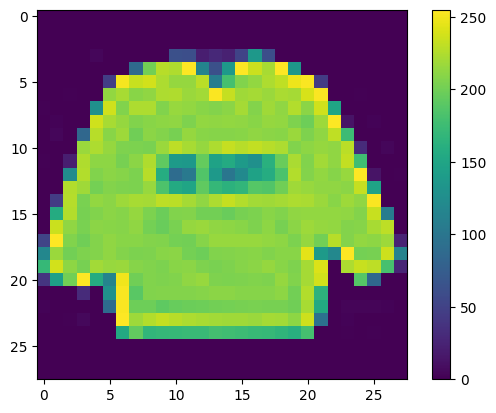

In [9]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.show()

### Scale the data

In [10]:
train_images = train_images / 255
test_images = test_images / 255

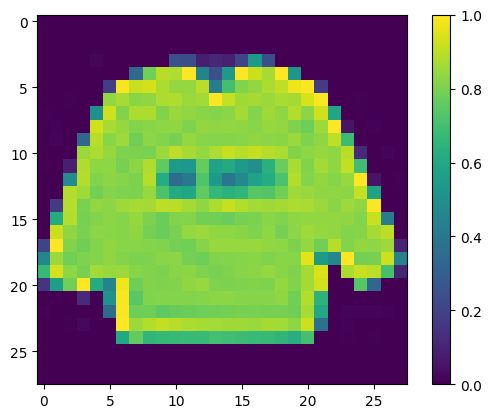

In [11]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.show()

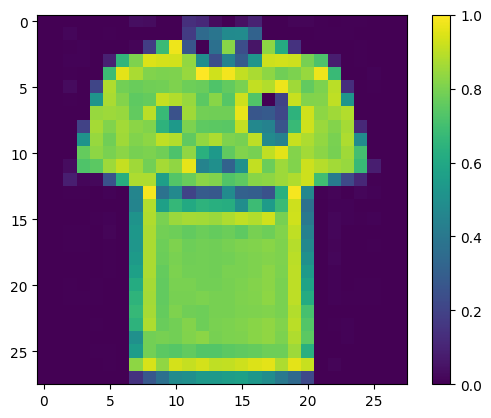

In [12]:
plt.figure()
plt.imshow(test_images[0])
plt.colorbar()
plt.show()

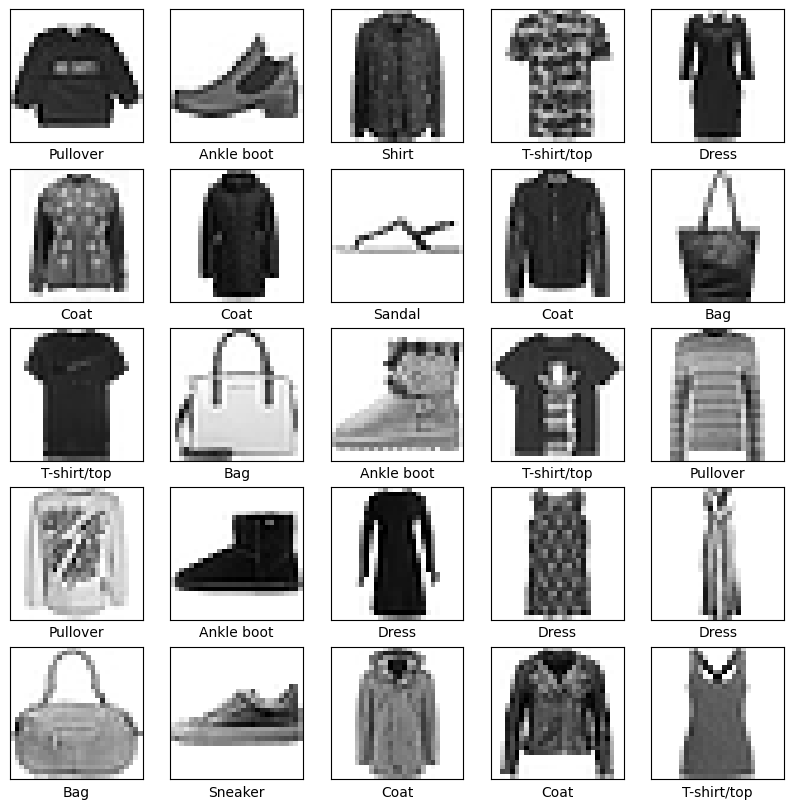

In [13]:
plt.figure(figsize = (10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### Encode the target feature

In [14]:
train_labels_encoded = pd.get_dummies(pd.Series(train_labels)).astype(int)
train_labels_encoded = np.asarray(train_labels_encoded)

test_labels_encoded = pd.get_dummies(pd.Series(test_labels)).astype(int)
test_labels_encoded = np.asarray(test_labels_encoded)

train_images = train_images.reshape(60000,-1)
test_images = test_images.reshape(10000, -1)

In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels_encoded, test_size=0.16666666666666666, shuffle=True, random_state=0)

In [16]:
X_test = test_images
Y_test = test_labels_encoded

### Fit the Stochastic Gradient Descent model to the data

In [17]:
sgd = SGD(eta=0.1, alpha=0.5, epochs=100, num_hidden=128, reg_parameter=0.01, random_state=1, debug=True)
sgd.fit(X_train, Y_train, X_val, Y_val)


KeyboardInterrupt



In [62]:
sgd.score(X_test, Y_test)

0.897

In [63]:
sgd.score(X_val, Y_val)

0.8913

In [64]:
sgd.score(X_train, Y_train)

0.94242

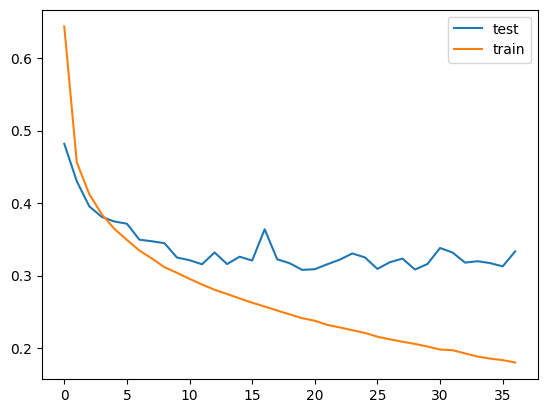

In [65]:
plt.figure()

plt.plot(np.asarray(sgd.validation_error))
plt.plot(np.asarray(sgd.training_error))

plt.legend(['test', 'train'])
plt.show()

### Fit the Scaled Conjugate Gradient model to the data

In [105]:
scg = SCG(num_hidden=128, random_state=1, reg_parameter=0.01, debug=True)
scg.fit(X_train, Y_train, X_val, Y_val)

Training error is: 2.343009098443008 and validation error is: 2.3428898329539924
Training error is: 2.343009098443008 and validation error is: 2.3428898329539924
Training error is: 2.0827758197015687 and validation error is: 2.082643339108452
Training error is: 1.7347419139263414 and validation error is: 1.738017016667051
Training error is: 1.460540884350135 and validation error is: 1.460444213943284
Training error is: 1.2975151331618568 and validation error is: 1.2979768253921913
Training error is: 1.216184544611327 and validation error is: 1.2102870715747311
Training error is: 1.1763738934983448 and validation error is: 1.168668805541238
Training error is: 1.153275060731988 and validation error is: 1.1475874070506653
Training error is: 1.145523464187796 and validation error is: 1.1403730992654757
Training error is: 1.1349657201116687 and validation error is: 1.1289045933176727
Training error is: 1.114232898464767 and validation error is: 1.1072274526744503
Training error is: 1.092069

In [106]:
scg.score(X_test, Y_test)

0.8426

In [107]:
scg.score(X_val, Y_val)

0.8417

In [108]:
scg.score(X_train, Y_train)

0.84226

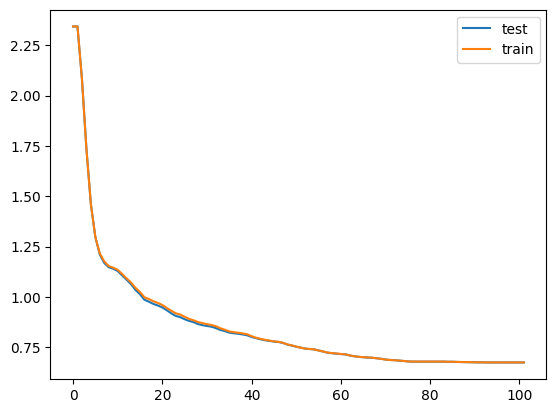

In [109]:
plt.figure()

plt.plot(np.asarray(scg.validation_error))
plt.plot(np.asarray(scg.training_error))

plt.legend(['test', 'train'])
plt.show()

### Fit the LeapFrog algorithm to the data

In [116]:
lf = LFrog(num_hidden=128, random_state=1, reg_parameter=0, debug=True, num_batches=64)
lf.fit(X_train, Y_train, X_val, Y_val)

Training error is: 2.252087621149547 and validation error is: 2.2509968426170994
Training error is: 2.121998866168284 and validation error is: 2.1214122356472296
Training error is: 1.9235655075909908 and validation error is: 1.9236693657843122
Training error is: 1.6387359495178497 and validation error is: 1.6387625716322132
Training error is: 1.3384091691568505 and validation error is: 1.339342418241877
Training error is: 1.0942904521183625 and validation error is: 1.0968218797535165
Training error is: 1.164337659525296 and validation error is: 1.149759511645456
Training error is: 2.110075557674243 and validation error is: 2.121398443348606
Training error is: 1.3126828753670994 and validation error is: 1.312198347172031
Training error is: 1.156510189886964 and validation error is: 1.1528679998378921
Training error is: 1.0042428556370417 and validation error is: 0.9973094723590058
Training error is: 0.9843214155036162 and validation error is: 0.9749578455057861
Training error is: 0.8761

In [117]:
lf.score(X_test, Y_test)

0.8893

In [118]:
lf.score(X_val, Y_val)

0.8875

In [119]:
lf.score(X_train, Y_train)

0.96148

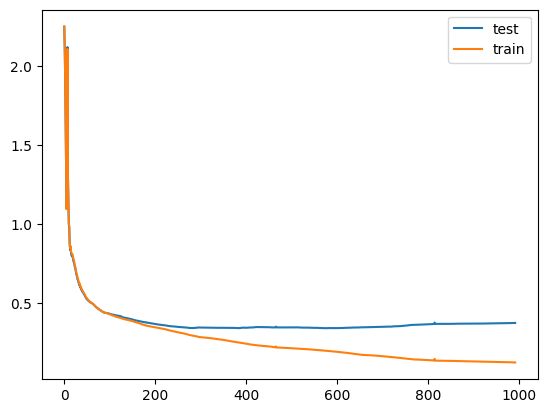

In [120]:
plt.figure()

plt.plot(np.asarray(lf.validation_error))
plt.plot(np.asarray(lf.training_error))

plt.legend(['test', 'train'])
plt.show()

# Perform hyperparameter tuning of the models

## Stochastic Gradient Descent

Testing with 2 hidden units
Average Train Error: 1.8495, Average Validation Error: 1.8492, Average Time: 669.2487
Testing with 4 hidden units
Average Train Error: 1.5587, Average Validation Error: 1.5596, Average Time: 741.7069
Testing with 8 hidden units
Average Train Error: 1.5592, Average Validation Error: 1.5621, Average Time: 75.5085
Testing with 16 hidden units
Average Train Error: 1.5316, Average Validation Error: 1.5347, Average Time: 112.0102
Testing with 32 hidden units
Average Train Error: 1.5684, Average Validation Error: 1.5704, Average Time: 106.3964
Testing with 64 hidden units
Average Train Error: 1.5302, Average Validation Error: 1.5302, Average Time: 150.8530
Testing with 128 hidden units
Average Train Error: 1.5237, Average Validation Error: 1.5273, Average Time: 341.4111
Testing with 256 hidden units
Average Train Error: 1.5305, Average Validation Error: 1.5331, Average Time: 3617.5666


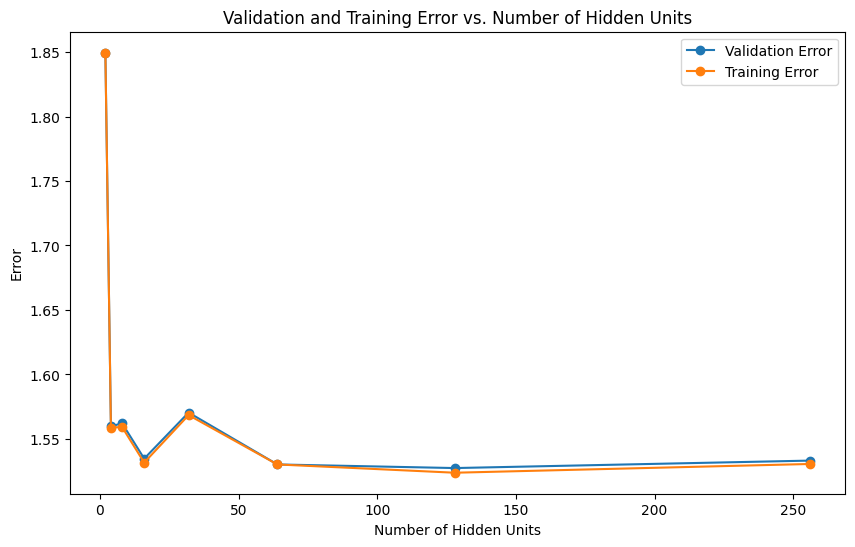

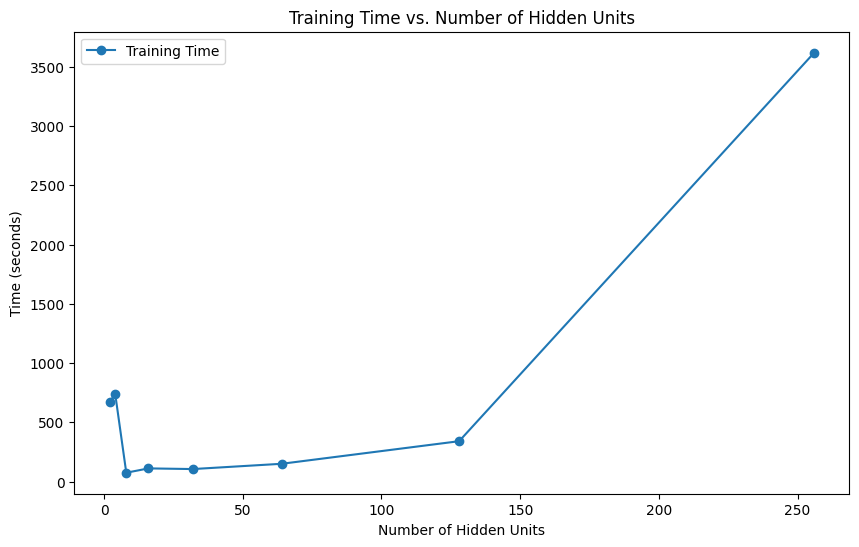

In [19]:
# import numpy as np
# import time
# from sklearn.model_selection import KFold
# from concurrent.futures import ThreadPoolExecutor, as_completed
# import matplotlib.pyplot as plt

# def process_fold(train_index, val_index, X_train, Y_train, num_hidden, count):
#     X_train_new, X_val = X_train[train_index], X_train[val_index]
#     Y_train_new, Y_val = Y_train[train_index], Y_train[val_index]
    
#     # Initialize the model with current number of hidden units
#     model = SGD(eta=0.01, alpha=0.1, epochs=10, num_hidden=num_hidden, reg_parameter=0.1, random_state=count)
    
#     # Train the model and measure the time taken
#     start_time = time.time()
#     model.fit(X_train_new, Y_train_new, X_val, Y_val)
#     end_time = time.time()
    
#     # Calculate training and validation errors
#     train_error = model.calculate_error(X_train_new, Y_train_new)
#     val_error = model.calculate_error(X_val, Y_val)
    
#     return train_error, val_error, end_time - start_time

# hidden_unit_options = [2, 4, 8, 16, 32, 64, 128, 256]
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# sgd_val_errors = []
# sgd_train_errors = []
# sgd_train_times = []
# sgd_all_val_errors = []
# sgd_all_training_errors = []

# for num_hidden in hidden_unit_options:
#     print(f"Testing with {num_hidden} hidden units")
#     val_errors_fold = []
#     train_errors_fold = []
#     fold_times = []
    
#     with ThreadPoolExecutor(max_workers=5) as executor:
#         future_to_fold = {executor.submit(process_fold, train_index, val_index, X_train, Y_train, num_hidden, i): i 
#                           for i, (train_index, val_index) in enumerate(kf.split(X_train), 1)}
        
#         for future in as_completed(future_to_fold):
#             train_error, val_error, fold_time = future.result()
#             train_errors_fold.append(train_error)
#             val_errors_fold.append(val_error)
#             fold_times.append(fold_time)
    
#     # Store the average results for this number of hidden units
#     sgd_train_errors.append(np.mean(train_errors_fold))
#     sgd_val_errors.append(np.mean(val_errors_fold))
#     sgd_train_times.append(np.mean(fold_times))
#     sgd_all_val_errors.append(val_errors_fold)
#     sgd_all_training_errors.append(train_errors_fold)
    
#     print(f"Average Train Error: {sgd_train_errors[-1]:.4f}, Average Validation Error: {sgd_val_errors[-1]:.4f}, Average Time: {sgd_train_times[-1]:.4f}")

# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(hidden_unit_options, sgd_val_errors, label='Validation Error', marker='o')
# plt.plot(hidden_unit_options, sgd_train_errors, label='Training Error', marker='o')
# plt.xlabel('Number of Hidden Units')
# plt.ylabel('Error')
# plt.title('Validation and Training Error vs. Number of Hidden Units')
# plt.legend()
# plt.show()

# # Plot training times
# plt.figure(figsize=(10, 6))
# plt.plot(hidden_unit_options, sgd_train_times, label='Training Time', marker='o')
# plt.xlabel('Number of Hidden Units')
# plt.ylabel('Time (seconds)')
# plt.title('Training Time vs. Number of Hidden Units')
# plt.legend()
# plt.show()

In [20]:
# stat, p_value = shapiro(sgd_all_val_errors)

# print(f'Statistic={stat}, p-value={p_value}')
# if p_value > 0.05:
#     print("Data is normally distributed")
# else:
#     print("Data is not normally distributed")

Statistic=0.7656762524870605, p-value=1.4041027803287074e-06
Data is not normally distributed


In [21]:
# stat, p_value = kruskal(*sgd_all_val_errors[0:15])
# print(f"Statistic: {stat}, p-value: {p_value}")

Statistic: 15.91902439024392, p-value: 0.0258665500193069


In [22]:
# # Perform statistical tests
# for i in range(len(hidden_unit_options) - 1):
#     n1, n2 = hidden_unit_options[i], hidden_unit_options[i+1]
#     errors1, errors2 = sgd_all_val_errors[i], sgd_all_val_errors[i+1]
    
#     # Paired t-test
#     t_stat, p_value = stats.ttest_rel(errors1, errors2)
    
#     # Effect size (Cohen's d)
#     mean_diff = np.mean(errors1) - np.mean(errors2)
#     pooled_std = np.sqrt((np.std(errors1, ddof=1)**2 + np.std(errors2, ddof=1)**2) / 2)
#     effect_size = mean_diff / pooled_std
    
#     print(f"\nComparing {n1} vs {n2} hidden units:")
#     print(f"Paired t-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
#     print(f"Effect size (Cohen's d): {effect_size:.4f}")

# # Calculate 95% confidence intervals and mean errors
# print("\n95% Confidence Intervals and Mean Errors:")
# for i, num_hidden in enumerate(hidden_unit_options):
#     errors = sgd_all_val_errors[i]
#     mean_error = np.mean(errors)
#     ci = stats.t.interval(0.95, len(errors)-1, loc=mean_error, scale=stats.sem(errors))
#     print(f"{num_hidden} hidden units: Mean Error = {mean_error:.4f}, 95% CI: {ci}")

# # One-way ANOVA
# f_statistic, p_value = stats.f_oneway(*sgd_all_val_errors)
# print(f"\nOne-way ANOVA: F-statistic = {f_statistic:.4f}, p-value = {p_value:.4f}")


Comparing 2 vs 4 hidden units:
Paired t-test: t-statistic = 7.5387, p-value = 0.0017
Effect size (Cohen's d): 4.6381

Comparing 4 vs 8 hidden units:
Paired t-test: t-statistic = -0.0573, p-value = 0.9570
Effect size (Cohen's d): -0.0392

Comparing 8 vs 16 hidden units:
Paired t-test: t-statistic = 0.6650, p-value = 0.5424
Effect size (Cohen's d): 0.4584

Comparing 16 vs 32 hidden units:
Paired t-test: t-statistic = -1.0610, p-value = 0.3485
Effect size (Cohen's d): -0.7995

Comparing 32 vs 64 hidden units:
Paired t-test: t-statistic = 1.6991, p-value = 0.1645
Effect size (Cohen's d): 1.2475

Comparing 64 vs 128 hidden units:
Paired t-test: t-statistic = 0.1145, p-value = 0.9144
Effect size (Cohen's d): 0.0775

Comparing 128 vs 256 hidden units:
Paired t-test: t-statistic = -0.2294, p-value = 0.8298
Effect size (Cohen's d): -0.1315

95% Confidence Intervals and Mean Errors:
2 hidden units: Mean Error = 1.8492, 95% CI: (1.7719363646172566, 1.9264858373412594)
4 hidden units: Mean Error 

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_fold(model, X, y, X_test, Y_test, train_indices, val_indices, fold_number):
    X_val, Y_val = X[val_indices], y[val_indices]
    Y_val = Y_val.reshape(-1, 10)
    X_train_new = X[train_indices].reshape(-1, 784)
    Y_train_new = y[train_indices].reshape(-1, 10)
    
    model.random_state = fold_number
    model.validation_error = []
    model.training_error = []
    model.fit(X_train_new, Y_train_new, X_val, Y_val)
    score = model.score(X_test, Y_test)
    return 1 - score

def cross_validate(model_class, model_params, X, y, X_test, Y_test, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    folds = list(kf.split(X))
    
    with ThreadPoolExecutor(max_workers=n_splits) as executor:
        future_to_fold = {}
        for n, (train_indices, val_indices) in enumerate(folds):
            future = executor.submit(
                process_fold, 
                model_class(**model_params), X, y, X_test, Y_test,
                train_indices, val_indices, 
                n
            )
            future_to_fold[future] = n
        
        scores = []
        for future in as_completed(future_to_fold):
            score = future.result()
            scores.append(score)
    
    return np.mean(scores)

def objective(params):
    eta, alpha, reg_parameter, num_epochs, num_hidden, bias_parameter = params
    print(params)
    model_params = {
        'eta': eta,
        'alpha': alpha,
        'epochs': num_epochs,
        'num_hidden': num_hidden,
        'reg_parameter': reg_parameter,
        'bias': bias_parameter
    }
    cv_score = cross_validate(SGD, model_params, train_images, train_labels_encoded, X_test, Y_test)
    
    return cv_score

# Define the hyperparameter search space
search_space = [
    Real(1e-3, 1e-1, "log-uniform", name='eta'),
    Real(0, 0.99, "uniform", name='alpha'),
    Real(1e-6, 1e-1, "log-uniform", name='reg_parameter'),
    Integer(5, 25, name='num_epochs'),
    Integer(1,128, name='num_hidden'),
    Real(-1, 1, name='bias_parameter')
]

# Run Bayesian optimization
result = gp_minimize(
    objective,
    search_space,
    n_calls=50,
    n_initial_points=20,
    random_state=0,
    n_jobs = -1,
    verbose=True
)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(f"Learning rate (eta): {result.x[0]}")
print(f"Momentum (alpha): {result.x[1]}")
print(f"Regularization (lambda): {result.x[2]}")
print(f"Number of epochs: {result.x[3]}")
print(f"Number of hidden units: {result.x[4]}")
print(f"Bias value: {result.x[5]}")

Iteration No: 1 started. Evaluating function at random point.
[0.015335192657991574, 0.8358230910952074, 0.019486241836466404, 22, 80, -0.23123658541460013]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3764.6357
Function value obtained: 0.5321
Current minimum: 0.5321
Iteration No: 2 started. Evaluating function at random point.
[0.003936128001463711, 0.05614584754426876, 2.3082427114609126e-05, 15, 104, -0.040045655249885126]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3342.7922
Function value obtained: 0.1097
Current minimum: 0.1097
Iteration No: 3 started. Evaluating function at random point.
[0.006103368503860312, 0.827717975902004, 4.863857046189474e-05, 18, 48, 0.9143103179060932]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1973.9438
Function value obtained: 0.1237
Current minimum: 0.1097
Iteration No: 4 started. Evaluating function at random point.
[0.0019085412933888726, 0.8613863857748523, 0.0002333674207996

In [18]:
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels_encoded, test_size=0.16666666666666666, shuffle=True, random_state=8)

In [ ]:
best_sgd_model = SGD(eta=0.003936128001463711, alpha=0.05614584754426876, reg_parameter=2.3082427114609126e-05, num_hidden=104, epochs=15, bias=-0.040045655249885126, random_state=42, debug=True)
best_sgd_model.fit(X_train, Y_train, X_val, Y_val)

In [ ]:
best_sgd_model.score(X_test, Y_test)

In [ ]:
best_sgd_model.score(X_val, Y_val)

In [ ]:
best_sgd_model.score(X_train, Y_train)

In [ ]:
plt.figure()

plt.plot(np.asarray(best_sgd_model.validation_error))
plt.plot(np.asarray(best_sgd_model.training_error))

plt.legend(['test', 'train'])
plt.show()

## Scaled Conjugate Gradient

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from joblib import Parallel, delayed  # Import joblib for parallelization

def process_fold(model, X, y, X_test, Y_test, train_indices, val_indices, fold_number):
    X_val, Y_val = X[val_indices], y[val_indices]
    Y_val = Y_val.reshape(-1, 10)
    X_train_new = X[train_indices].reshape(-1, 784)
    Y_train_new = y[train_indices].reshape(-1, 10)
    
    model.random_state = fold_number
    model.validation_error = []
    model.training_error = []
    model.lambda_bar = 0
    model.lambda_parameter = 1e-6
    model.fit(X_train_new, Y_train_new, X_val, Y_val)
    score = model.score(X_test, Y_test)
    return 1 - score

def cross_validate(model_class, model_params, X, y, X_test, Y_test, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    folds = list(kf.split(X))

    # Use joblib's Parallel to execute tasks in parallel
    scores = Parallel(n_jobs=n_splits)(
        delayed(process_fold)(
            model_class(**model_params), X, y, X_test, Y_test, train_indices, val_indices, n
        )
        for n, (train_indices, val_indices) in enumerate(folds)
    )

    print(scores)
    return np.mean(scores)

# Define the objective function to minimize (validation error)
def objective(params):
    reg_parameter, num_epochs, num_hidden, bias_parameter = params
    print(params)
    model_params = {
        'epochs': num_epochs, 
        'num_hidden': num_hidden, 
        'reg_parameter': reg_parameter, 
        'bias': bias_parameter
    }
    cv_score = cross_validate(SCG, model_params, train_images, train_labels_encoded, X_test, Y_test)
    
    return cv_score

# Define the hyperparameter search space
search_space = [
    Real(1e-6, 1e-1, "log-uniform", name='reg_parameter'),
    Integer(10, 500, name='num_epochs'),
    Integer(64,128, name='num_hidden'),
    Real(-1, 1, name='bias_parameter')
]

# Run Bayesian optimization
result = gp_minimize(
    objective,
    search_space,
    n_calls=20,
    n_initial_points=20,
    random_state=0,
    n_jobs=1,
    verbose=True
)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(f"Regularization (lambda): {result.x[0]}")
print(f"Number of epochs: {result.x[1]}")
print(f"Number of hidden units: {result.x[2]}")
print(f"Bias value: {result.x[3]}")

Iteration No: 1 started. Evaluating function at random point.
[0.0009209225155490904, 424, 119, 0.6945034775682513]
[0.1279, 0.128, 0.1291, 0.12280000000000002, 0.12549999999999994]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4314.9423
Function value obtained: 0.1267
Current minimum: 0.1267
Iteration No: 2 started. Evaluating function at random point.
[0.0013116515715358098, 198, 83, -0.8865740453651136]
[0.13580000000000003, 0.13419999999999999, 0.1421, 0.13370000000000004, 0.1391]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1846.3579
Function value obtained: 0.1370
Current minimum: 0.1267
Iteration No: 3 started. Evaluating function at random point.
[2.3082427114609126e-05, 244, 116, -0.040045655249885126]
[0.1362, 0.14229999999999998, 0.12919999999999998, 0.14190000000000003, 0.13880000000000003]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2427.3417
Function value obtained: 0.1377
Current minimum: 0.1267
Iterati

In [ ]:
# import numpy as np
# from sklearn.model_selection import KFold
# from concurrent.futures import ThreadPoolExecutor, as_completed

# def process_fold(model, X, y, X_test, Y_test, train_indices, val_indices, fold_number):
#     X_val, Y_val = X[val_indices], y[val_indices]
#     Y_val = Y_val.reshape(-1, 10)
#     X_train_new = X[train_indices].reshape(-1, 784)
#     Y_train_new = y[train_indices].reshape(-1, 10)
    
#     model.random_state = fold_number
#     model.validation_error = []
#     model.training_error = []
#     model.lambda_bar = 0
#     model.lambda_parameter = 1e-6
#     model.fit(X_train_new, Y_train_new, X_val, Y_val)
#     score = model.score(X_test, Y_test)
#     return 1 - score

# def cross_validate(model_class, model_params, X, y, X_test, Y_test, n_splits=5):
#     kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
#     folds = list(kf.split(X))
    
#     with ThreadPoolExecutor(max_workers=n_splits) as executor:
#         future_to_fold = {}
#         for n, (train_indices, val_indices) in enumerate(folds):
#             future = executor.submit(
#                 process_fold, 
#                 model_class(**model_params), X, y, X_test, Y_test,
#                 train_indices, val_indices, 
#                 n
#             )
#             future_to_fold[future] = n
        
#         scores = []
#         for future in as_completed(future_to_fold):
#             score = future.result()
#             scores.append(score)
#     print(scores)
#     return np.mean(scores)

# # Define the objective function to minimize (validation error)
# def objective(params):
#     reg_parameter, num_epochs, num_hidden, bias_parameter = params
#     print(params)
#     model_params = {
#         'epochs': num_epochs, 
#         'num_hidden': num_hidden, 
#         'reg_parameter': reg_parameter, 
#         'bias': bias_parameter
#     }
#     cv_score = cross_validate(SCG, model_params, train_images, train_labels_encoded, X_test, Y_test)
    
#     return cv_score

# # Define the hyperparameter search space
# search_space = [
#     Real(1e-6, 1e-1, "log-uniform", name='reg_parameter'),
#     Integer(100, 1000, name='num_epochs'),
#     Integer(1,128, name='num_hidden'),
#     Real(-1, 1, name='bias_parameter')
# ]

# # Run Bayesian optimization
# result = gp_minimize(
#     objective,
#     search_space,
#     n_calls=50,
#     n_initial_points=20,
#     random_state=0,
#     n_jobs = -1,
#     verbose=True
# )

# # Print the best hyperparameters found
# print("Best hyperparameters found:")
# print(f"Regularization (lambda): {result.x[0]}")
# print(f"Number of epochs: {result.x[1]}")
# print(f"Number of hidden units: {result.x[2]}")
# print(f"Bias value: {result.x[3]}")

In [17]:
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels_encoded, test_size=0.16666666666666666, shuffle=True, random_state=8)

In [18]:
best_scg_model = SCG(epochs=420, num_hidden=86, reg_parameter=9.202884691104563e-05, bias=0.2963437441023946, random_state=42)
best_scg_model.fit(X_train, Y_train, X_val, Y_val)

In [19]:
best_scg_model.score(X_test, Y_test)

0.8787

In [20]:
best_scg_model.score(X_val, Y_val)

0.8769

In [21]:
best_scg_model.score(X_train, Y_train)

0.89254

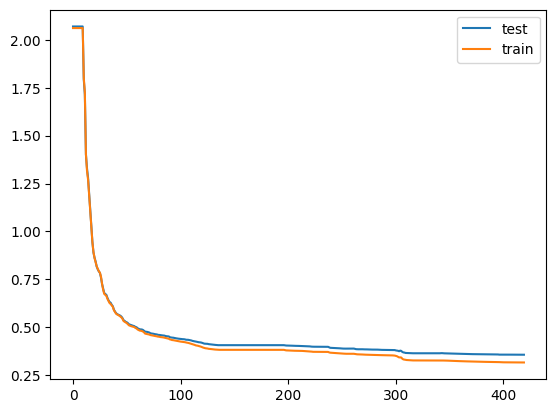

In [22]:
plt.figure()

plt.plot(np.asarray(best_scg_model.validation_error))
plt.plot(np.asarray(best_scg_model.training_error))

plt.legend(['test', 'train'])
plt.show()

# Leap Frog

In [17]:
import numpy as np
from sklearn.model_selection import KFold
from joblib import Parallel, delayed

def process_fold(model, X, y, X_test, Y_test, train_indices, val_indices, fold_number):
    X_val, Y_val = X[val_indices], y[val_indices]
    Y_val = Y_val.reshape(-1, 10)
    X_train_new = X[train_indices].reshape(-1, 784)
    Y_train_new = y[train_indices].reshape(-1, 10)
    
    model.random_state = fold_number
    model.validation_error = []
    model.training_error = []
    model.fit(X_train_new, Y_train_new, X_val, Y_val)
    score = model.score(X_test, Y_test)
    return 1 - score

def cross_validate(model_class, model_params, X, y, X_test, Y_test, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    folds = list(kf.split(X))

    # Use joblib's Parallel and delayed to parallelize the process
    scores = Parallel(n_jobs=n_splits)(delayed(process_fold)(
        model_class(**model_params), X, y, X_test, Y_test, train_indices, val_indices, n
    ) for n, (train_indices, val_indices) in enumerate(folds))
    
    return np.mean(scores)

def objective(params):
    reg_parameter, num_epochs, num_batches, num_hidden, bias_parameter = params
    print(params)
    model_params = {
        'epochs': num_epochs,
        'num_hidden': num_hidden,
        'reg_parameter': reg_parameter,
        'num_batches': num_batches,
        'bias': bias_parameter
    }
    # Perform cross-validation
    cv_score = cross_validate(LFrog, model_params, train_images, train_labels_encoded, X_test, Y_test)
    
    return cv_score  # Return mean cross-validation error

# Define the hyperparameter search space
search_space = [
    Real(1e-6, 1e-1, "log-uniform", name='reg_parameter'),
    Integer(10, 250, name='num_epochs'),
    Integer(32, 128, name='num_batches'),
    Integer(64, 128, name='num_hidden'),
    Real(-1, 1, name='bias_parameter')
]

# Run Bayesian optimization
result = gp_minimize(
    objective,
    search_space,
    n_calls=20,
    n_initial_points=20,
    random_state=0,
    n_jobs=1,  # This will use multiple jobs for the optimization
    verbose=True
)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(f"Regularization (lambda): {result.x[0]}")
print(f"Number of epochs: {result.x[1]}")
print(f"Number of batches: {result.x[2]}")
print(f"Number of hidden units: {result.x[3]}")
print(f"Bias value: {result.x[4]}")

Iteration No: 1 started. Evaluating function at random point.
[0.0009209225155490904, 213, 114, 118, 0.2471273935719449]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 962.0849
Function value obtained: 0.1432
Current minimum: 0.1432
Iteration No: 2 started. Evaluating function at random point.
[8.354270566129826e-05, 81, 37, 81, -0.04466976535730005]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 362.6248
Function value obtained: 0.1744
Current minimum: 0.1432
Iteration No: 3 started. Evaluating function at random point.
[0.011503861485898605, 125, 70, 118, -0.3252076791654631]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 596.6748
Function value obtained: 0.1602
Current minimum: 0.1432
Iteration No: 4 started. Evaluating function at random point.
[0.0017412429067220003, 98, 124, 73, 0.7401745167168732]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 510.0302
Function value obtained: 0.1586
Current mini

In [ ]:
# import numpy as np
# from sklearn.model_selection import KFold
# from concurrent.futures import ThreadPoolExecutor, as_completed

# def process_fold(model, X, y, X_test, Y_test, train_indices, val_indices, fold_number):
#     X_val, Y_val = X[val_indices], y[val_indices]
#     Y_val = Y_val.reshape(-1, 10)
#     X_train_new = X[train_indices].reshape(-1, 784)
#     Y_train_new = y[train_indices].reshape(-1, 10)
    
#     model.random_state = fold_number
#     model.validation_error = []
#     model.training_error = []
#     model.fit(X_train_new, Y_train_new, X_val, Y_val)
#     score = model.score(X_test, Y_test)
#     return 1 - score

# def cross_validate(model_class, model_params, X, y, X_test, Y_test, n_splits=5):
#     kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
#     folds = list(kf.split(X))
    
#     with ThreadPoolExecutor(max_workers=n_splits) as executor:
#         future_to_fold = {}
#         for n, (train_indices, val_indices) in enumerate(folds):
#             future = executor.submit(
#                 process_fold, 
#                 model_class(**model_params), X, y, X_test, Y_test,
#                 train_indices, val_indices, 
#                 n
#             )
#             future_to_fold[future] = n
        
#         scores = []
#         for future in as_completed(future_to_fold):
#             score = future.result()
#             scores.append(score)
    
#     return np.mean(scores)

# def objective(params):
#     reg_parameter, num_epochs, num_batches, num_hidden, bias_parameter = params
#     print(params)
#     model_params = {
#         'epochs': num_epochs,
#         'num_hidden': num_hidden,
#         'reg_parameter': reg_parameter,
#         'num_batches': num_batches,
#         'bias': bias_parameter
#     }
#     # Perform cross-validation
#     cv_score = cross_validate(LFrog, model_params, train_images, train_labels_encoded, X_test, Y_test)
    
#     return cv_score  # Return mean cross-validation error

# # Define the hyperparameter search space
# search_space = [
#     Real(1e-6, 1e-1, "log-uniform", name='reg_parameter'),
#     Integer(10, 250, name='num_epochs'),
#     Integer(1, 128, name='num_batches'),
#     Integer(1,128, name='num_hidden'),
#     Real(-1, 1, name='bias_parameter')
# ]

# # Run Bayesian optimization
# result = gp_minimize(
#     objective,
#     search_space,
#     n_calls=50,
#     n_initial_points=20,
#     random_state=0,
#     n_jobs = -1,
#     verbose=True
# )

# # Print the best hyperparameters found
# print("Best hyperparameters found:")
# print(f"Regularization (lambda): {result.x[0]}")
# print(f"Number of epochs: {result.x[1]}")
# print(f"Number of batches: {result.x[2]}")
# print(f"Number of hidden units: {result.x[3]}")
# print(f"Bias value: {result.x[4]}")

In [18]:
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels_encoded, test_size=0.16666666666666666, shuffle=True, random_state=42)

In [19]:
best_lf_model = LFrog(epochs=result.x[1], num_hidden=result.x[3], reg_parameter=result.x[0], num_batches=result.x[2], bias=result.x[4], random_state=0)
best_lf_model.fit(X_train, Y_train, X_val, Y_val)

In [19]:
best_lf_model = LFrog(epochs=227, num_hidden=126, reg_parameter=0.00116229746185022, num_batches=42, bias=0.30628007159587556, random_state=0)
best_lf_model.fit(X_train, Y_train, X_val, Y_val)

In [20]:
best_lf_model.score(X_test, Y_test)

0.8736

In [21]:
best_lf_model.score(X_val, Y_val)

0.8722

In [22]:
best_lf_model.score(X_train, Y_train)

0.88858

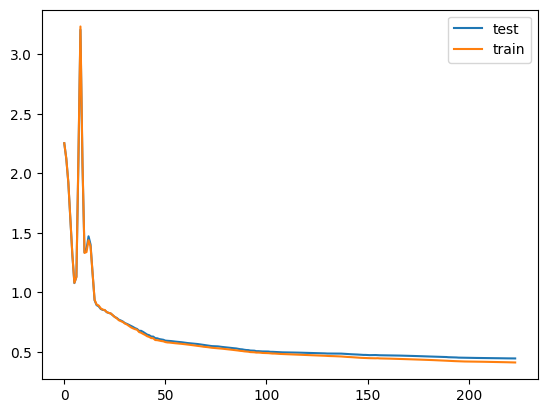

In [23]:
plt.figure()

plt.plot(np.asarray(best_lf_model.validation_error))
plt.plot(np.asarray(best_lf_model.training_error))

plt.legend(['test', 'train'])
plt.show()

# Compare the 3 types of models against one another

In [17]:
best_sgd_model = SGD(eta=0.003936128001463711, alpha=0.05614584754426876, reg_parameter=2.3082427114609126e-05, num_hidden=104, epochs=15, bias=-0.040045655249885126)
best_scg_model = SCG(epochs=420, num_hidden=86, reg_parameter=9.202884691104563e-05, bias=0.2963437441023946)
best_lf_model = LFrog(epochs=227, num_hidden=126, reg_parameter=0.00116229746185022, num_batches=42, bias=0.30628007159587556)

In [18]:
from joblib import Parallel, delayed
from sklearn.model_selection import KFold
import numpy as np
import time
import sys

def process_fold(model, X, y, X_test, y_test, train_indices, val_indices, fold_number, model_name):
    X_val, Y_val = X[val_indices], y[val_indices]
    Y_val = Y_val.reshape(-1, 10)
    X_train = X[train_indices].reshape(-1, 784)
    Y_train = y[train_indices].reshape(-1, 10)
    
    model.random_state = fold_number + 10
    model.validation_error = []
    model.training_error = []
    if model_name == "Scaled Conjugate Gradient":
        model.lambda_bar = 0
        model.lambda_parameter = 1e-6
    start_time = time.time()
    model.fit(X_train, Y_train, X_val, Y_val)
    end_time = time.time()
    fit_time = end_time - start_time
    score = model.score(X_test, y_test)
    return score, fit_time

def cross_validate(model, X, y, name, X_test, y_test, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    folds = [list(val_index) for _, val_index in kf.split(X)]
    
    def process_fold_wrapper(n):
        val_indices = folds[n]
        train_folds = folds.copy()
        train_folds.remove(folds[n])
        train_indices = np.concatenate(train_folds)
        
        result = process_fold(model, X, y, X_test, y_test, train_indices, val_indices, n, name)
        print(f'Completed fold {n+1}/{n_splits} for {name}', end='\r')
        sys.stdout.flush()
        return result
    
    results = Parallel(n_jobs=5, backend="loky")(
        delayed(process_fold_wrapper)(n) for n in range(n_splits)
    )
    
    print()  # Move to the next line after progress updates
    scores, times = zip(*results)
    return list(scores), list(times)

# Main execution
models = [best_sgd_model, best_scg_model, best_lf_model]
model_names = ['Stochastic Gradient Descent', 'Scaled Conjugate Gradient', 'Leap Frog Optimiser']
model_cv_scores = []
model_cv_times = []

for name, model in zip(model_names, models):
    print(f"\nCross-validating {name}:")
    scores, times = cross_validate(model, train_images, train_labels_encoded, name, X_test, Y_test)
    model_cv_scores.append(scores)
    model_cv_times.append(times)
    print(f"Completed cross-validation for {name}")
    print(f"Mean score: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    print(f"Mean time: {np.mean(times):.2f}s ± {np.std(times):.2f}s")


Cross-validating Stochastic Gradient Descent:

Completed cross-validation for Stochastic Gradient Descent
Mean score: 0.8812 ± 0.0050
Mean time: 4129.87s ± 1306.38s

Cross-validating Scaled Conjugate Gradient:

Completed cross-validation for Scaled Conjugate Gradient
Mean score: 0.8707 ± 0.0064
Mean time: 6424.27s ± 2932.92s

Cross-validating Leap Frog Optimiser:

Completed cross-validation for Leap Frog Optimiser
Mean score: 0.8702 ± 0.0033
Mean time: 1110.35s ± 18.42s


In [19]:
for name, scores in zip(model_names, model_cv_scores):
    print(f"{name}: Mean accuracy = {np.mean(scores):.4f} (+/- {np.std(scores) * 2:.4f})")

Stochastic Gradient Descent: Mean accuracy = 0.8812 (+/- 0.0100)
Scaled Conjugate Gradient: Mean accuracy = 0.8707 (+/- 0.0128)
Leap Frog Optimiser: Mean accuracy = 0.8702 (+/- 0.0067)


In [20]:
stat, p_value = shapiro(model_cv_scores)

print(f'Statistic={stat}, p-value={p_value}')
if p_value > 0.05:
    print("Data is normally distributed")
else:
    print("Data is not normally distributed")

Statistic=0.9810612900366417, p-value=0.8530218465330249
Data is normally distributed


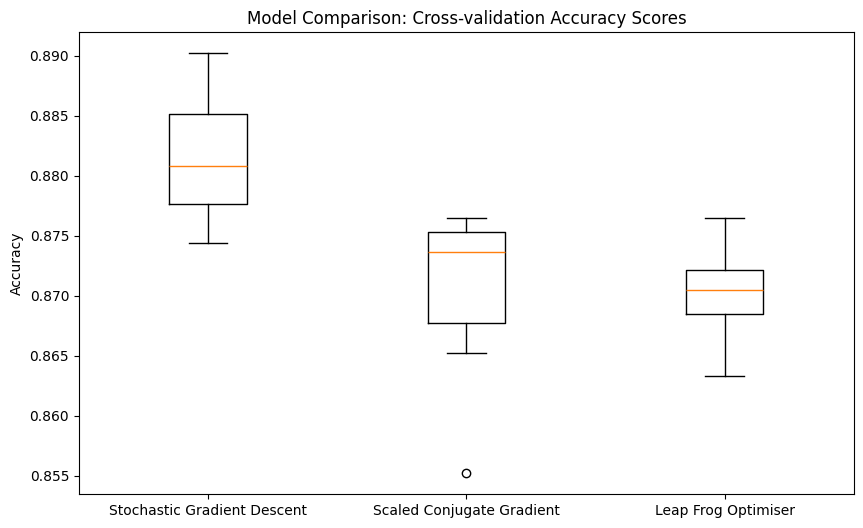

In [22]:
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels_encoded, test_size=0.16666666666666666, shuffle=True, random_state=100)

# Train the best model on the entire training set and evaluate on the test set
# best_model_index = np.argmax([np.mean(scores) for scores in model_cv_scores])
# best_model = models[best_model_index]
# best_model.fit(X_train, Y_train, X_val, Y_val)
# test_accuracy = best_model.score(X_test, Y_test)
# print(f"\nBest model ({model_names[best_model_index]}) test accuracy: {test_accuracy:.4f}")

# Visualize the results
plt.figure(figsize=(10, 6))
plt.boxplot(model_cv_scores, labels=model_names)
plt.title('Model Comparison: Cross-validation Accuracy Scores')
plt.ylabel('Accuracy')
plt.show()

In [24]:
stat, p_value = kruskal(*model_cv_scores)
print(f"Statistic: {stat}, p-value: {p_value}")

Statistic: 15.619207656354341, p-value: 0.0004058187899470557


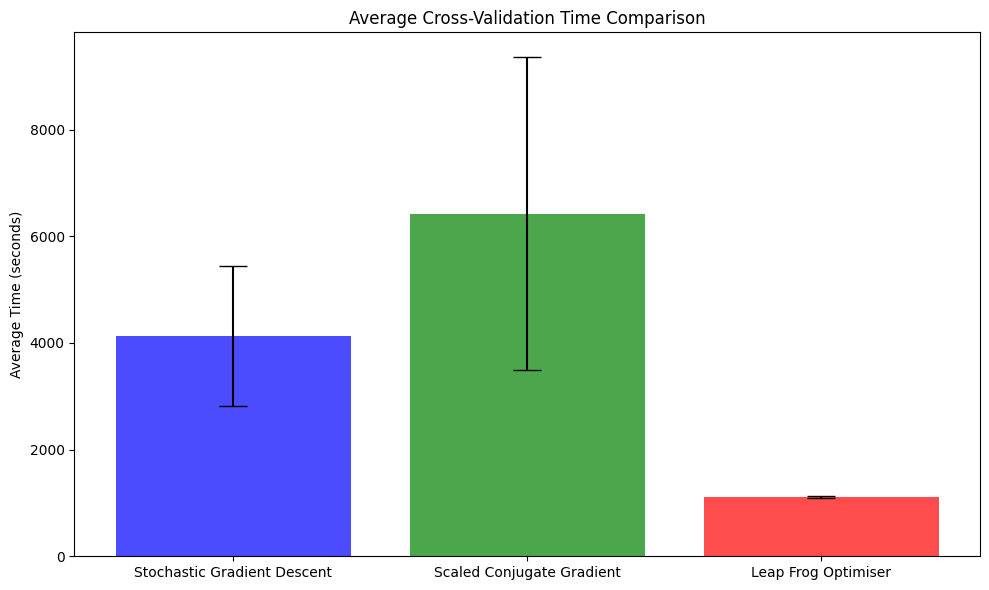

In [25]:
mean_times = [np.mean(times) for times in model_cv_times]
std_times = [np.std(times) for times in model_cv_times]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(model_names))

ax.bar(x_pos, mean_times, yerr=std_times, align='center', alpha=0.7, capsize=10, color=['blue', 'green', 'red'])
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names)
ax.set_ylabel('Average Time (seconds)')
ax.set_title('Average Cross-Validation Time Comparison')
# ax.yaxis.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

In [26]:
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels_encoded, test_size=0.16666666666666666, shuffle=True, random_state=43)

In [27]:
Y_test_decoded = ['T-shirt/top' if u == 0 else 'Trouser' if u == 1 else 'Pullover' if u == 2 else 'Dress' if u == 3 else 'Coat' if u == 4
                  else 'Sandal' if u == 5 else 'Shirt' if u == 6 else 'Sneaker' if u == 7 else 'Bag' if u ==8 else 'Ankle boot'
                  for u in Y_test.argmax(axis=1)]

In [30]:
from joblib import Parallel, delayed

def fit_model(model, X_train, Y_train, X_val, Y_val):
    model_name = type(model).__name__
    print(f"Starting to fit {model_name}...")
    model.fit(X_train, Y_train, X_val, Y_val)
    print(f"{model_name} has completed fitting.")
    return model

def parallel_fit_models(models, X_train, Y_train, X_val, Y_val):
    fitted_models = Parallel(n_jobs=-1, backend="loky")(
        delayed(fit_model)(model, X_train, Y_train, X_val, Y_val) for model in models
    )
    
    for fitted_model in fitted_models:
        print(f"Model {type(fitted_model).__name__} has been successfully fitted and is ready for use.")

    return fitted_models

# Usage
models = [best_sgd_model, best_scg_model, best_lf_model]
fitted_models = parallel_fit_models(models, X_train, Y_train, X_val, Y_val)

Model SGD has been successfully fitted and is ready for use.
Model SCG has been successfully fitted and is ready for use.
Model LFrog has been successfully fitted and is ready for use.


In [41]:
Y_pred_sgd = fitted_models[0].predict(X_test)
Y_pred_sgd = ['T-shirt/top' if u == 0 else 'Trouser' if u == 1 else 'Pullover' if u == 2 else 'Dress' if u == 3 else 'Coat' if u == 4
                  else 'Sandal' if u == 5 else 'Shirt' if u == 6 else 'Sneaker' if u == 7 else 'Bag' if u ==8 else 'Ankle boot'
                  for u in Y_pred_sgd.argmax(axis=1)]

Y_pred_scg = fitted_models[1].predict(X_test)
Y_pred_scg = ['T-shirt/top' if u == 0 else 'Trouser' if u == 1 else 'Pullover' if u == 2 else 'Dress' if u == 3 else 'Coat' if u == 4
                  else 'Sandal' if u == 5 else 'Shirt' if u == 6 else 'Sneaker' if u == 7 else 'Bag' if u ==8 else 'Ankle boot'
                  for u in Y_pred_scg.argmax(axis=1)]

Y_pred_lf = fitted_models[2].predict(X_test)
Y_pred_lf = ['T-shirt/top' if u == 0 else 'Trouser' if u == 1 else 'Pullover' if u == 2 else 'Dress' if u == 3 else 'Coat' if u == 4
                  else 'Sandal' if u == 5 else 'Shirt' if u == 6 else 'Sneaker' if u == 7 else 'Bag' if u ==8 else 'Ankle boot'
                  for u in Y_pred_lf.argmax(axis=1)]

In [42]:
print(classification_report(Y_test_decoded, Y_pred_sgd))

              precision    recall  f1-score   support

  Ankle boot       0.98      0.90      0.94      1000
         Bag       0.97      0.97      0.97      1000
        Coat       0.78      0.86      0.82      1000
       Dress       0.90      0.91      0.90      1000
    Pullover       0.85      0.73      0.79      1000
      Sandal       0.93      0.96      0.94      1000
       Shirt       0.70      0.68      0.69      1000
     Sneaker       0.91      0.94      0.93      1000
 T-shirt/top       0.81      0.86      0.83      1000
     Trouser       0.99      0.97      0.98      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [43]:
print(classification_report(Y_test_decoded, Y_pred_scg))

              precision    recall  f1-score   support

  Ankle boot       0.94      0.96      0.95      1000
         Bag       0.95      0.96      0.95      1000
        Coat       0.79      0.82      0.81      1000
       Dress       0.88      0.89      0.88      1000
    Pullover       0.79      0.80      0.79      1000
      Sandal       0.95      0.93      0.94      1000
       Shirt       0.70      0.66      0.68      1000
     Sneaker       0.92      0.92      0.92      1000
 T-shirt/top       0.82      0.81      0.81      1000
     Trouser       0.97      0.97      0.97      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [44]:
print(classification_report(Y_test_decoded, Y_pred_lf))

              precision    recall  f1-score   support

  Ankle boot       0.93      0.96      0.94      1000
         Bag       0.94      0.96      0.95      1000
        Coat       0.77      0.82      0.79      1000
       Dress       0.87      0.89      0.88      1000
    Pullover       0.79      0.77      0.78      1000
      Sandal       0.96      0.92      0.94      1000
       Shirt       0.71      0.61      0.66      1000
     Sneaker       0.91      0.93      0.92      1000
 T-shirt/top       0.80      0.82      0.81      1000
     Trouser       0.97      0.97      0.97      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



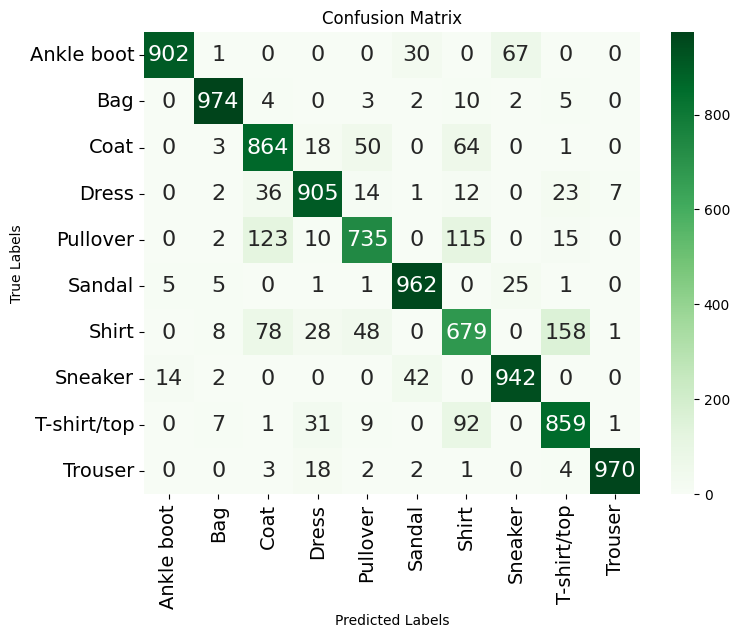

In [45]:
# Create confusion matrix
cm = confusion_matrix(Y_test_decoded, Y_pred_sgd)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=np.unique(Y_test_decoded), yticklabels=np.unique(Y_test_decoded), annot_kws={"size": 16})

# Adding labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tick_params(axis='both', which='major', labelsize=14)

# Display the plot
plt.show()

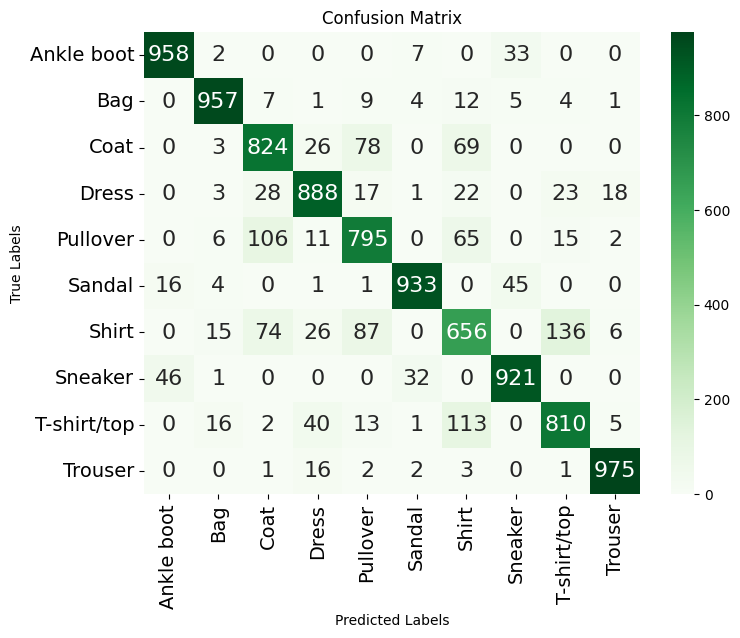

In [46]:
# Create confusion matrix
cm = confusion_matrix(Y_test_decoded, Y_pred_scg)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=np.unique(Y_test_decoded), yticklabels=np.unique(Y_test_decoded), annot_kws={"size": 16})

# Adding labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tick_params(axis='both', which='major', labelsize=14)

# Display the plot
plt.show()

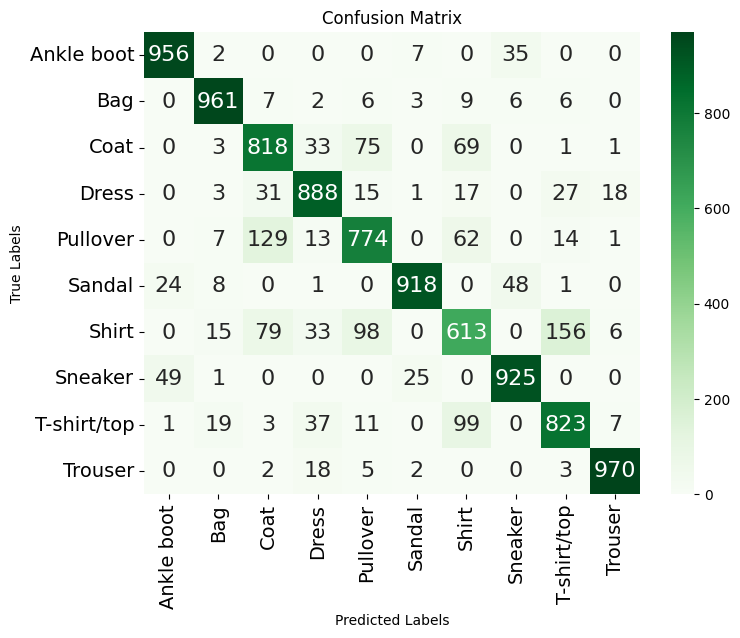

In [47]:
# Create confusion matrix
cm = confusion_matrix(Y_test_decoded, Y_pred_lf)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=np.unique(Y_test_decoded), yticklabels=np.unique(Y_test_decoded), annot_kws={"size": 16})

# Adding labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tick_params(axis='both', which='major', labelsize=14)

# Display the plot
plt.show()

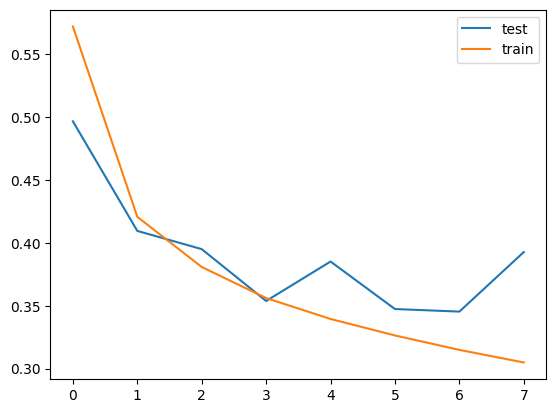

In [49]:
plt.figure()

plt.plot(np.asarray(fitted_models[0].validation_error))
plt.plot(np.asarray(fitted_models[0].training_error))

plt.legend(['test', 'train'])
plt.show()

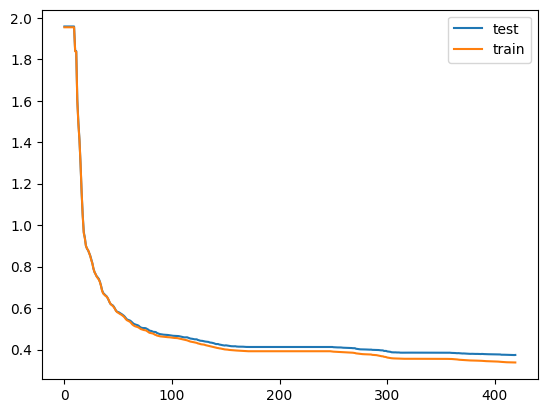

In [50]:
plt.figure()

plt.plot(np.asarray(fitted_models[1].validation_error))
plt.plot(np.asarray(fitted_models[1].training_error))

plt.legend(['test', 'train'])
plt.show()

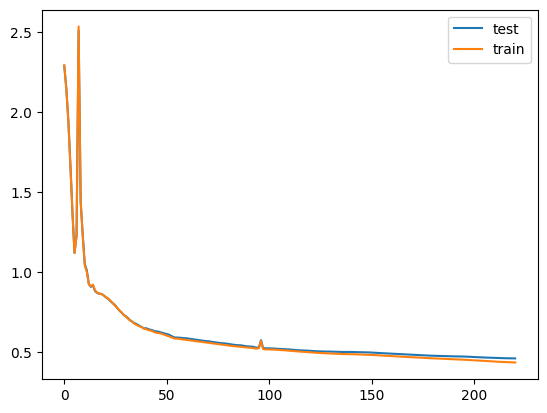

In [51]:
plt.figure()

plt.plot(np.asarray(fitted_models[2].validation_error))
plt.plot(np.asarray(fitted_models[2].training_error))

plt.legend(['test', 'train'])
plt.show()